In [1]:
#imports only
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.discriminant_analysis as skl_da
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score


In [2]:
file_path = 'siren_data_train.csv'
data = pd.read_csv(file_path)
data.head()

,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age
0,2712,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59
1,2721,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29
2,297,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32
3,739,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36
4,1852,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55


In [3]:
#add distance to horn
# Calculate Euclidean distance between person and nearest horn
data['dist'] = np.sqrt((data['xcoor'] - data['near_x'])**2 + (data['ycoor'] - data['near_y'])**2)


In [4]:
data = data.drop(columns=["near_fid"], axis=1) #drop near_fid as it doesnt make sense to have (is only an ID)
semi_original_data = data.copy() #make copy to be able to use later

# Data exploration

In [5]:
# Check correlations between attributes
#from pandas.plotting import scatter_matrix

#attributes = data.columns
#scatter_matrix(data[attributes], figsize=(12,8))

### Distance

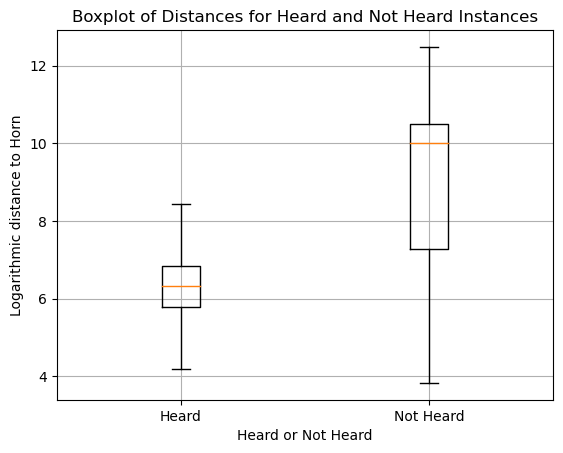

In [6]:
df = data


data['dist_log'] = np.log(data['dist']) #not doing this gives really strange boxplots where the boxes are hard to see
data

log_dist_heard = df[df['heard'] == 1]['dist_log']
log_dist_not_heard = df[df['heard'] == 0]['dist_log']


all_distances = [log_dist_heard, log_dist_not_heard]

plt.boxplot(all_distances, labels=['Heard', 'Not Heard'], showfliers=False)
plt.title('Boxplot of Distances for Heard and Not Heard Instances')
plt.xlabel('Heard or Not Heard')
plt.ylabel('Logarithmic distance to Horn')
plt.grid(True)
plt.show()


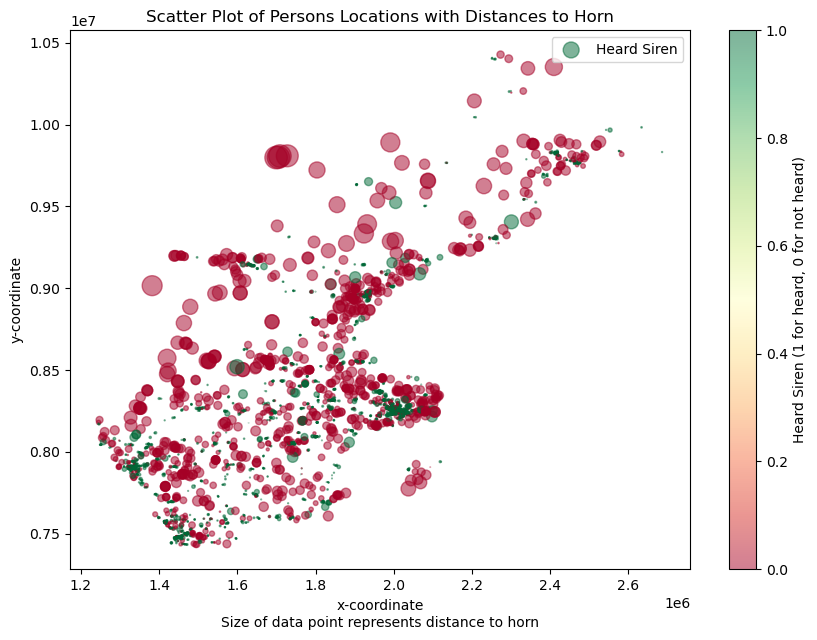

In [7]:
scaling_factor = 0.001  #scaling the distance as some distances are huge

plt.figure(figsize=(10, 7))
scatter = plt.scatter(data["xcoor"], data["ycoor"], alpha=0.5, 
                      c=data["heard"], cmap='RdYlGn', label="Heard Siren",
                      s=data["dist"] * scaling_factor, marker='o')
plt.colorbar(scatter, label='Heard Siren (1 for heard, 0 for not heard)')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Scatter Plot of Persons Locations with Distances to Horn')
plt.legend()

plt.text(0.5, -0.1, "Size of data point represents distance to horn", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()


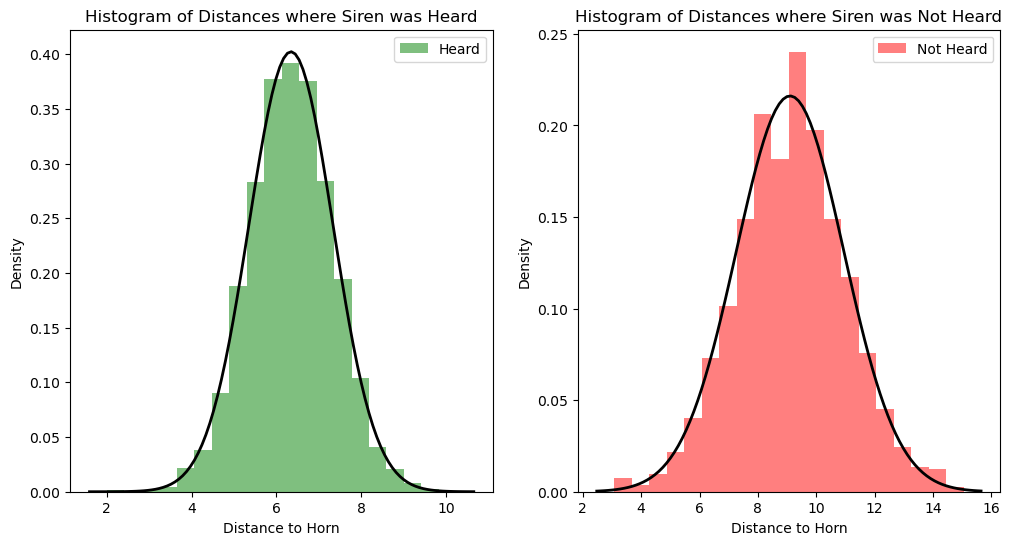

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate synthetic data following a Gaussian distribution for heard and not heard distances
mu_heard = np.mean(log_dist_heard)  # Mean of the distribution for heard distances
sigma_heard = np.std(log_dist_heard)  # Standard deviation of the distribution for heard distances
num_samples_heard = len(log_dist_heard)  # Number of samples for heard distances

mu_not_heard = np.mean(log_dist_not_heard)  # Mean of the distribution for not heard distances
sigma_not_heard = np.std(log_dist_not_heard)  # Standard deviation of the distribution for not heard distances
num_samples_not_heard = len(log_dist_not_heard)  # Number of samples for not heard distances

# Generate synthetic data for heard distances
distances_heard = np.random.normal(mu_heard, sigma_heard, num_samples_heard)

# Generate synthetic data for not heard distances
distances_not_heard = np.random.normal(mu_not_heard, sigma_not_heard, num_samples_not_heard)

# Plot the histograms for heard and not heard distances
plt.figure(figsize=(12, 6))

# Plot for heard distances
plt.subplot(1, 2, 1)
plt.hist(distances_heard, bins=20, density=True, alpha=0.5, color='green', label='Heard')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_heard, sigma_heard)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Distance to Horn')
plt.ylabel('Density')
plt.title('Histogram of Distances where Siren was Heard')
plt.legend()

# Plot for not heard distances
plt.subplot(1, 2, 2)
plt.hist(distances_not_heard, bins=20, density=True, alpha=0.5, color='red', label='Not Heard')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_not_heard, sigma_not_heard)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Distance to Horn')
plt.ylabel('Density')
plt.title('Histogram of Distances where Siren was Not Heard')
plt.legend()

plt.show()


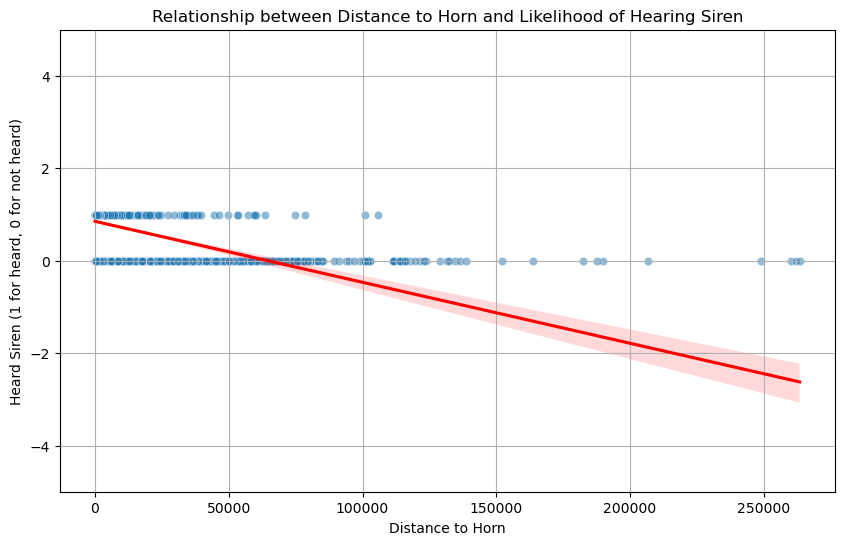

In [9]:
# Assuming 'dist' represents distance and 'heard' represents whether the siren was heard (1 for heard, 0 for not heard)

# Plotting the relationship between distance and likelihood of hearing the siren
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dist', y='heard', data=data, alpha=0.5)

# Fitting a trend line (e.g., linear regression) to visualize the relationship
sns.regplot(x='dist', y='heard', data=data, scatter=False, color='red')

plt.xlabel('Distance to Horn')
plt.ylabel('Heard Siren (1 for heard, 0 for not heard)')
plt.title('Relationship between Distance to Horn and Likelihood of Hearing Siren')

# Set y-axis limits from -3 to 3
plt.ylim(-5, 5)

plt.grid(True)
plt.show()


In [10]:
#### Is there a statistical difference between those that heard the signal and those that didn't given the distance?

# Generate sample data
np.random.seed(0)
heard_distances = data[data['heard'] == 1]['dist']
not_heard_distances = data[data['heard'] == 0]['dist']

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(heard_distances, not_heard_distances)

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in mean distances between the heard and not heard groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in mean distances between the heard and not heard groups.")


T-statistic: -51.7056653375075
P-value: 0.0
Reject null hypothesis: There is a significant difference in mean distances between the heard and not heard groups.


## Age

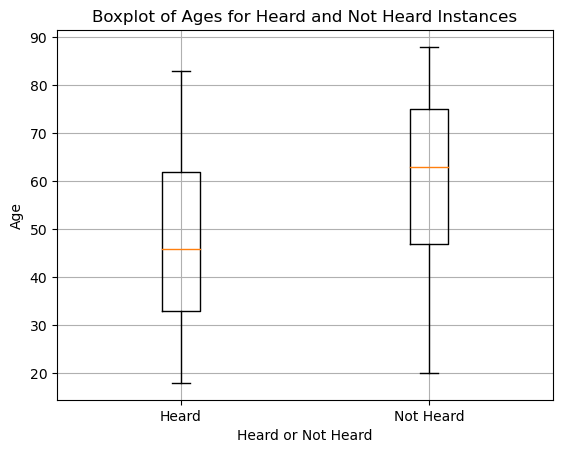

In [11]:
df = data

age_heard = df[df['heard'] == 1]['age']
age_not_heard = df[df['heard'] == 0]['age']

all_ages = [age_heard, age_not_heard]

plt.boxplot(all_ages, labels=['Heard', 'Not Heard'])
plt.title('Boxplot of Ages for Heard and Not Heard Instances')
plt.xlabel('Heard or Not Heard')
plt.ylabel('Age')
plt.grid(True)
plt.show()


In [12]:
# Generate sample data
np.random.seed(0)
heard_distances = data[data['heard'] == 1]['age']
not_heard_distances = data[data['heard'] == 0]['age']

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(heard_distances, not_heard_distances)

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in mean ages between the heard and not heard groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in mean ages between the heard and not heard groups.")


T-statistic: -22.79964593973161
P-value: 3.3998771811922806e-110
Reject null hypothesis: There is a significant difference in mean ages between the heard and not heard groups.


### Angles

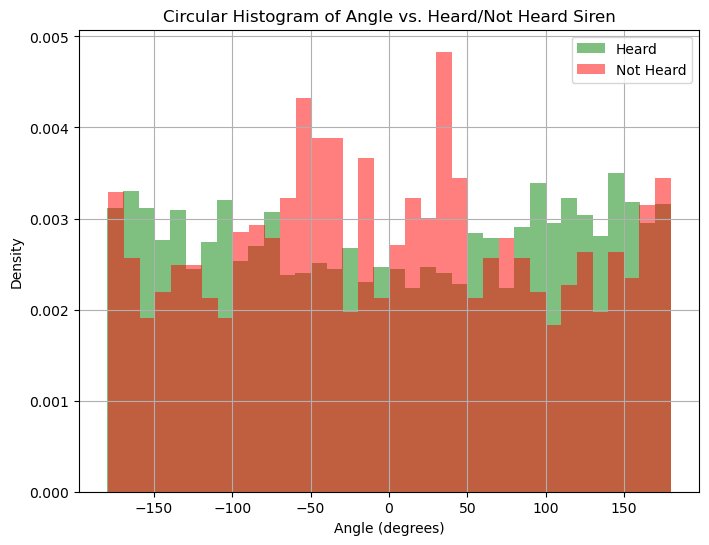

In [13]:
# Extracting data for instances where the siren was heard and not heard
angles_heard = data[data['heard'] == 1]['near_angle']
angles_not_heard = data[data['heard'] == 0]['near_angle']

# Creating a circular histogram for the angles
plt.figure(figsize=(8, 6))

# Plotting histogram for instances where siren was heard
plt.hist(angles_heard, bins=36, density=True, alpha=0.5, color='green', label='Heard')

# Plotting histogram for instances where siren was not heard
plt.hist(angles_not_heard, bins=36, density=True, alpha=0.5, color='red', label='Not Heard')

plt.title('Circular Histogram of Angle vs. Heard/Not Heard Siren')
plt.xlabel('Angle (degrees)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

# Setting polar coordinates
#plt.gca().set_theta_zero_location('N')
#plt.gca().set_theta_direction(-1)

plt.show()


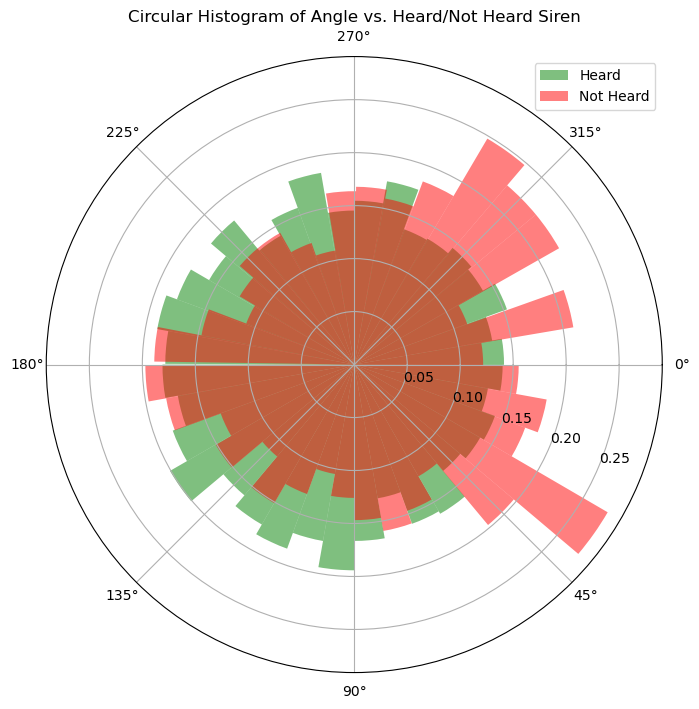

In [14]:
# Assuming 'near_angle' represents the angle data and 'heard' represents whether the siren was heard (1 for heard, 0 for not heard)

# Separate angles for instances where the siren was heard and not heard
angles_heard = data[data['heard'] == 1]['near_angle']
angles_not_heard = data[data['heard'] == 0]['near_angle']

# Create a polar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plot angles where the siren was heard
ax.hist(np.radians(angles_heard), bins=36, density=True, alpha=0.5, color='green', label='Heard')

# Plot angles where the siren was not heard
ax.hist(np.radians(angles_not_heard), bins=36, density=True, alpha=0.5, color='red', label='Not Heard')

# Set the direction of the polar plot as clockwise
ax.set_theta_direction(-1)

# Add a legend
plt.legend()
plt.title('Circular Histogram of Angle vs. Heard/Not Heard Siren')

plt.show()


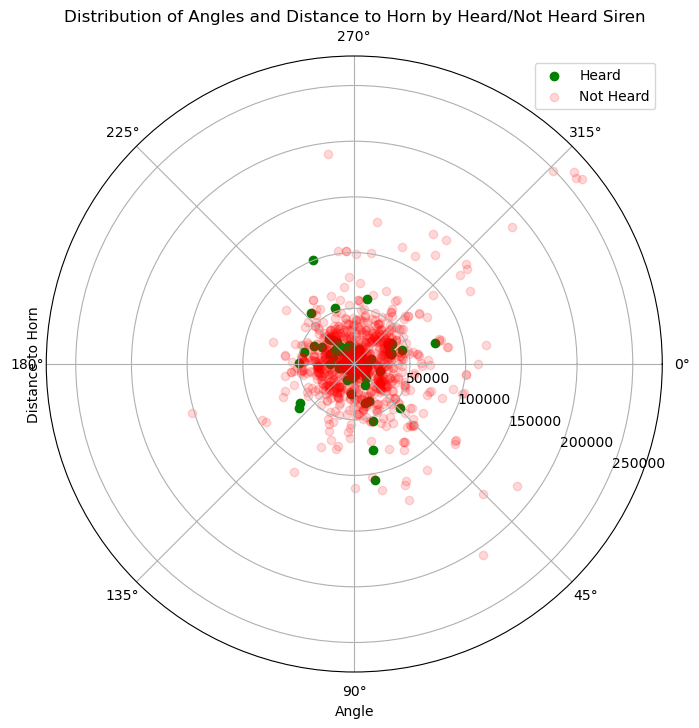

In [15]:
# Assuming 'near_angle' represents the angle data, 'heard' represents whether the siren was heard (1 for heard, 0 for not heard),
# and 'dist' represents the distance to the horn

# Separate angles and distances for instances where the siren was heard and not heard
angles_heard = data[data['heard'] == 1]['near_angle']
angles_not_heard = data[data['heard'] == 0]['near_angle']

distances_heard = data[data['heard'] == 1]['dist']
distances_not_heard = data[data['heard'] == 0]['dist']

# Create a polar plot
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

# Plot angles where the siren was heard
ax.scatter(np.radians(angles_heard), distances_heard, alpha=1, color='green', label='Heard')

# Plot angles where the siren was not heard
ax.scatter(np.radians(angles_not_heard), distances_not_heard, alpha=0.15, color='red', label='Not Heard')

# Set the direction of the polar plot as clockwise
ax.set_theta_direction(-1)

# Add labels and title
plt.xlabel('Angle')
plt.ylabel('Distance to Horn')
plt.title('Distribution of Angles and Distance to Horn by Heard/Not Heard Siren')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [16]:
#import numpy as np
#from scipy.stats import ttest_ind

# Generate sample data
np.random.seed(0)
heard_distances = data[data['heard'] == 1]['near_angle']
not_heard_distances = data[data['heard'] == 0]['near_angle']

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(heard_distances, not_heard_distances)

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in mean angles between the heard and not heard groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in mean angles between the heard and not heard groups.")


T-statistic: 0.512822563157527
P-value: 0.6080952897476064
Fail to reject null hypothesis: There is no significant difference in mean angles between the heard and not heard groups.


### Check correlations



In [17]:
data_copy = data.copy()
#data_copy_dum = pd.get_dummies(data, columns=["heard", "building", "noise", "in_vehicle", "asleep", "no_windows"])
data_copy

,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,dist,dist_log
0,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59,901.283517,6.803820
1,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29,972.006260,6.879362
2,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32,872.340924,6.771180
3,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36,257.804449,5.552201
4,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55,529.686791,6.272286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5705,2.008871e+06,8.255775e+06,-176.234663,1,0,2009140.0,8255793,0,0,0,0,29,269.161517,5.595312
5706,1.981871e+06,8.270452e+06,45.691415,1,0,1981119.0,8269682,0,0,0,0,49,1076.700725,6.981657
5707,1.463760e+06,8.074997e+06,-175.473118,1,0,1464308.0,8075040,0,0,0,0,62,549.581267,6.309157
5708,1.479843e+06,7.526377e+06,142.958054,1,0,1480125.0,7526164,0,0,0,0,37,353.136892,5.866856


In [18]:
#data_copy_dum_wo_categorical.columns

In [19]:
data_copy

,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,dist,dist_log
0,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59,901.283517,6.803820
1,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29,972.006260,6.879362
2,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32,872.340924,6.771180
3,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36,257.804449,5.552201
4,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55,529.686791,6.272286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5705,2.008871e+06,8.255775e+06,-176.234663,1,0,2009140.0,8255793,0,0,0,0,29,269.161517,5.595312
5706,1.981871e+06,8.270452e+06,45.691415,1,0,1981119.0,8269682,0,0,0,0,49,1076.700725,6.981657
5707,1.463760e+06,8.074997e+06,-175.473118,1,0,1464308.0,8075040,0,0,0,0,62,549.581267,6.309157
5708,1.479843e+06,7.526377e+06,142.958054,1,0,1480125.0,7526164,0,0,0,0,37,353.136892,5.866856


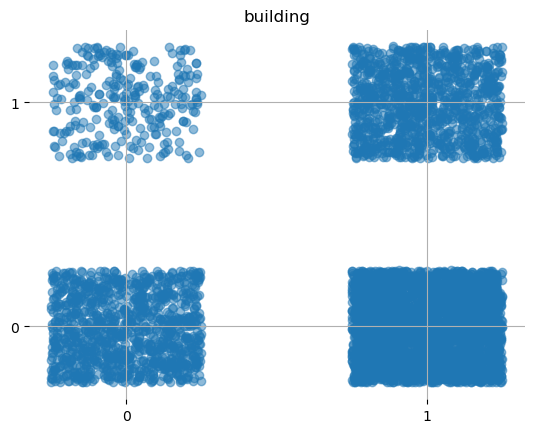

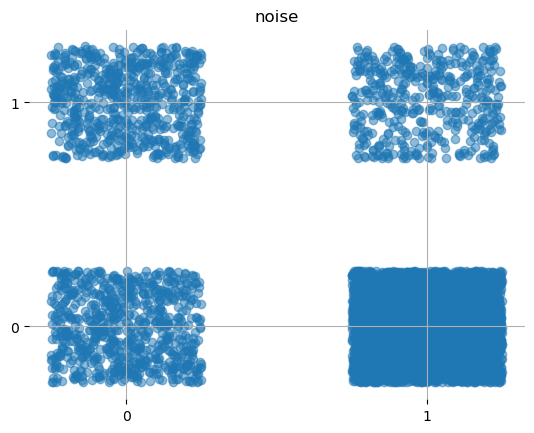

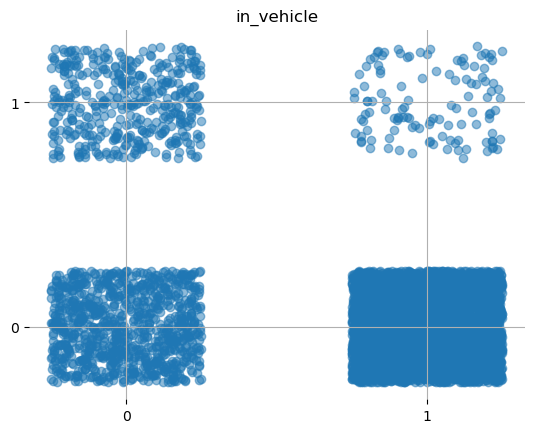

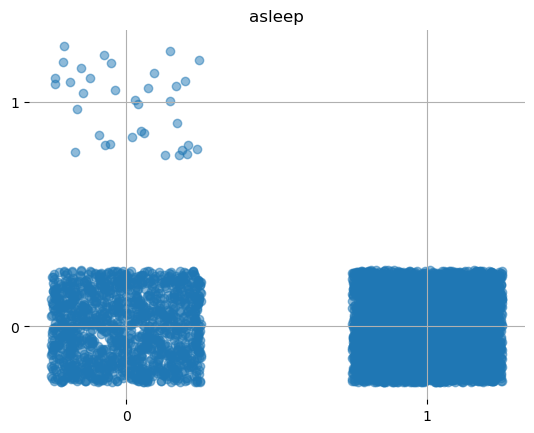

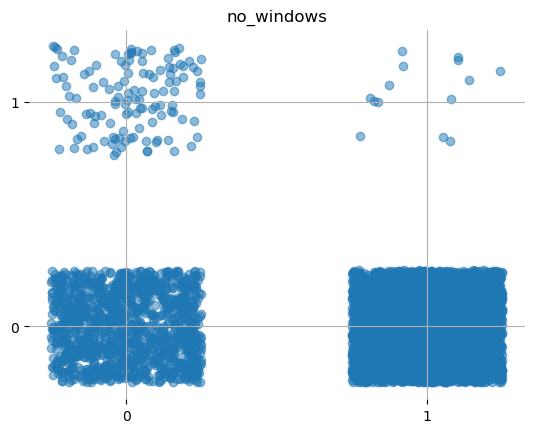

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def check_two_categorical_variables(target_variable_string, comparison_variable_string):
    # This is to encode the data into numbers that can be used in our scatterplot
    from sklearn.preprocessing import OrdinalEncoder
    ord_enc = OrdinalEncoder()
    enc_data = ord_enc.fit_transform(data_copy)
    enc_df = pd.DataFrame(enc_data, columns=data_copy.columns)
    # Get the categories from the ordinal encoder
    categories = ord_enc.categories_
    
    
    # Generate the random noise
    xnoise, ynoise = np.random.random(len(data_copy))/2, np.random.random(len(data_copy))/2 # The noise is in the range 0 to 0.5
    
    # Plot the scatterplot
    plt.figure()
    plt.scatter(enc_df[target_variable_string]+xnoise, enc_df[comparison_variable_string]+ynoise, alpha=0.5)
    target_index = data_copy.columns.get_loc(target_variable_string)
    comparison_index = data_copy.columns.get_loc(comparison_variable_string)
    
    plt.xticks([0.25, 1.25], categories[target_index]) # Adjust as per your category values
    plt.yticks([0.25, 1.25], categories[comparison_index]) # Adjust as per your category values
    plt.title(comparison_variable_string)
    
    plt.grid()
    sns.despine(left=True, bottom=True)

comparison_array = ["building", "noise", "in_vehicle", "asleep", "no_windows"]

for feature in comparison_array:
    check_two_categorical_variables("heard", feature)

#This result gives reason that we can combine these categorical variables into at least one variable, but possible two


In [22]:

def combine_attributes(row):
    # one hot encoding
    if row['in_vehicle'] == 1 and row['asleep'] == 1 and row['no_windows'] == 1:
        return 3
    elif row['asleep'] == 1 and row['no_windows'] == 1:
        return 2
    elif row['no_windows'] == 1:
        return 1
    else:
        return 0

# Apply the function to create the combined attribute
data['combined'] = data.apply(combine_attributes, axis=1)

In [23]:

#def combine_attributes(row):
    # one hot encoding
    #if row['building'] == 1 and row['noise'] == 1 and row['in_vehicle'] == 1 and row['asleep'] == 1 and row['no_windows'] == 1:
      #  return 5
    #elif row['building'] == 1 and row['noise'] == 1 and row['in_vehicle'] == 1 and row['asleep'] == 1:
      #  return 4
    #elif row['building'] == 1 and row['noise'] == 1 and row['in_vehicle'] == 1:
       # return 3
    #elif row['building'] == 1 and row['noise'] == 1:
       # return 2
    #elif row['building'] == 1:
       # return 1
   # else:
      #  return 0

# Apply the function to create the combined attribute
#data['combined'] = data.apply(combine_attributes, axis=1)

In [24]:
data

,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,dist,dist_log,combined
0,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59,901.283517,6.803820,0
1,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29,972.006260,6.879362,0
2,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32,872.340924,6.771180,0
3,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36,257.804449,5.552201,0
4,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55,529.686791,6.272286,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5705,2.008871e+06,8.255775e+06,-176.234663,1,0,2009140.0,8255793,0,0,0,0,29,269.161517,5.595312,0
5706,1.981871e+06,8.270452e+06,45.691415,1,0,1981119.0,8269682,0,0,0,0,49,1076.700725,6.981657,0
5707,1.463760e+06,8.074997e+06,-175.473118,1,0,1464308.0,8075040,0,0,0,0,62,549.581267,6.309157,0
5708,1.479843e+06,7.526377e+06,142.958054,1,0,1480125.0,7526164,0,0,0,0,37,353.136892,5.866856,0


In [25]:
#subset_data = data[data['combined'] >= 1]
#subset_data

In [26]:
corr_matrix = data.corr()
corr_matrix["heard"].sort_values(ascending=False)

heard         1.000000
building      0.063283
near_angle    0.006788
xcoor         0.002301
near_x       -0.003943
near_y       -0.121353
ycoor        -0.121918
asleep       -0.139777
combined     -0.236544
no_windows   -0.239178
age          -0.288908
noise        -0.400162
in_vehicle   -0.406263
dist         -0.564778
dist_log     -0.685484
Name: heard, dtype: float64

In [27]:
all_data = data.copy()

data = data.copy().drop(columns=["asleep", "no_windows", "in_vehicle"], axis=1)

In [28]:
data

,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,age,dist,dist_log,combined
0,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,59,901.283517,6.803820,0
1,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,29,972.006260,6.879362,0
2,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,32,872.340924,6.771180,0
3,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,36,257.804449,5.552201,0
4,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,55,529.686791,6.272286,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5705,2.008871e+06,8.255775e+06,-176.234663,1,0,2009140.0,8255793,0,29,269.161517,5.595312,0
5706,1.981871e+06,8.270452e+06,45.691415,1,0,1981119.0,8269682,0,49,1076.700725,6.981657,0
5707,1.463760e+06,8.074997e+06,-175.473118,1,0,1464308.0,8075040,0,62,549.581267,6.309157,0
5708,1.479843e+06,7.526377e+06,142.958054,1,0,1480125.0,7526164,0,37,353.136892,5.866856,0


# Creating age grouping

In [29]:
#new bins based on hearing with age research
new_age_bins = [0, 40, 50, 60, 70, float('inf')]
new_age_labels = ['0-39', '40-49', '50-59', '60-69', '70+']
data['age_group'] = pd.cut(data['age'], bins=new_age_bins, labels=new_age_labels, right=False)


In [30]:
data = pd.get_dummies(data, columns=["age_group"])


In [31]:
data.head(10)

,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,age,dist,dist_log,combined,age_group_0-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70+
0,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,59,901.283517,6.803820,0,0,0,1,0,0
1,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,29,972.006260,6.879362,0,1,0,0,0,0
2,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,32,872.340924,6.771180,0,1,0,0,0,0
3,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,36,257.804449,5.552201,0,1,0,0,0,0
4,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,55,529.686791,6.272286,0,0,0,1,0,0
5,1.934971e+06,8.959613e+06,-159.477621,0,1,1938739.0,8961023,0,62,4023.130333,8.299816,1,0,0,0,1,0
6,1.327964e+06,7.940968e+06,18.712045,1,1,1327733.0,7940890,0,74,244.293455,5.498370,0,0,0,0,0,1
7,2.005312e+06,8.234592e+06,146.602179,1,0,2007113.0,8233405,0,24,2157.250580,7.676590,0,1,0,0,0,0
8,2.010260e+06,8.244737e+06,91.888991,1,0,2010284.0,8244010,0,66,727.512654,6.589631,0,0,0,0,1,0
9,1.339570e+06,7.892866e+06,160.654726,1,1,1340898.0,7892400,0,53,1407.236379,7.249383,0,0,0,1,0,0


# Generate train & test set

In [131]:
#random sampling with shuffling built-in
def split_train_test(data, test_ratio, random_state): 
    shuffled_indices = np.random.permutation(len(data)) if random_state is None else np.random.RandomState(random_state).permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


#stratified sampling, where we create a sample that takes the distribution of heard into account
def stratified_sampling(data, test_ratio, important_data_column):
    split = StratifiedShuffleSplit(n_splits=1, test_size = test_ratio, random_state=42) 
    for train_index, test_index in split.split(data, important_data_column):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    return strat_train_set, strat_test_set


#create samples
train, test = stratified_sampling(data, 0.15, data["heard"])

#train, test = split_train_test(data, 0.15, random_state=42)

X_train = train.drop(columns=['heard'])
y_train = train['heard']

# Extract features and target for testing set
X_test = test.drop(columns=['heard'])
y_test = test['heard']

TypeError: stratified_sampling() got an unexpected keyword argument 'shuffle'

In [33]:
X_train

,near_x,near_y,near_angle,building,xcoor,ycoor,noise,age,dist,dist_log,combined,age_group_0-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70+
4358,1.799918e+06,8.094107e+06,109.182714,0,1800154.0,8093428,0,53,718.744812,6.577506,0,0,0,1,0,0
2051,1.728344e+06,7.684640e+06,-41.604494,1,1701767.0,7708240,0,44,35542.323900,10.478479,0,0,1,0,0,0
3631,1.619509e+06,8.252418e+06,113.564643,1,1619889.0,8251547,0,21,950.201363,6.856674,0,1,0,0,0,0
310,1.807248e+06,8.336481e+06,-72.606428,0,1802941.0,8350229,0,31,14406.383847,9.575427,0,1,0,0,0,0
719,1.998784e+06,8.258579e+06,153.242866,1,1999205.0,8258367,0,55,471.256926,6.155403,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2277,2.008014e+06,8.255314e+06,-82.650477,0,2007966.0,8255689,0,82,378.127604,5.935232,0,0,0,0,0,1
358,1.926927e+06,8.973239e+06,-10.970233,0,1903217.0,8977835,0,67,24151.705170,10.092110,0,0,0,0,1,0
1744,1.450990e+06,7.454638e+06,-159.422444,1,1459400.0,7457795,0,73,8983.023275,9.103092,0,0,0,0,0,1
767,1.921416e+06,8.952792e+06,43.165041,0,1898048.0,8930875,1,79,32037.654272,10.374667,0,0,0,0,0,1


In [34]:
y_test

192     1
3264    1
2315    1
4748    1
689     1
       ..
2653    0
3485    1
11      1
4848    0
4287    1
Name: heard, Length: 857, dtype: int64

# Models

## LDA
Remove age groupings as that has a really high (infinity) VIF score as well as coordinates as they have a high VIF

In [116]:
X_train.columns

Index(['near_x', 'near_y', 'near_angle', 'building', 'xcoor', 'ycoor', 'noise',
       'age', 'dist', 'dist_log', 'combined', 'age_group_0-39',
       'age_group_40-49', 'age_group_50-59', 'age_group_60-69',
       'age_group_70+'],
      dtype='object')

In [125]:
#columns_to_remove = []
columns_to_remove = ['age_group_0-39',
       'age_group_40-49', 'age_group_50-59', 'age_group_60-69',
       'age_group_70+', 'near_x', 'near_y', 'xcoor', 'ycoor', "dist"]

X_train_LDA = X_train.drop(columns=columns_to_remove , axis=1)
X_test_LDA = X_test.drop(columns=columns_to_remove , axis=1)



In [126]:
X_train_LDA

,near_angle,building,noise,age,dist_log,combined
4358,109.182714,0,0,53,6.577506,0
2051,-41.604494,1,0,44,10.478479,0
3631,113.564643,1,0,21,6.856674,0
310,-72.606428,0,0,31,9.575427,0
719,153.242866,1,0,55,6.155403,0
...,...,...,...,...,...,...
2277,-82.650477,0,0,82,5.935232,0
358,-10.970233,0,0,67,10.092110,0
1744,-159.422444,1,0,73,9.103092,0
767,43.165041,0,1,79,10.374667,0


In [127]:
#Checking VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor variable
vif_data = X_train_LDA.copy()
vif_data['Intercept'] = 1  # Adding an intercept column for VIF calculation
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

print(vif)

     Variable        VIF
0  near_angle   1.001073
1    building   1.118068
2       noise   1.104213
3         age   1.050894
4    dist_log   1.174521
5    combined   1.090924
6   Intercept  23.955198


In [128]:
#My own feature selector

columns = X_train_LDA.columns
for column in columns:
    column_to_remove = column
    print("Column that was removed: ", column)
    columns_to_remove = [column]
    X_train_temp = X_train_LDA.copy().drop(columns=columns_to_remove, axis=1)
    y_train_temp = y_train
    
    # Extract features and target for testing set
    X_test_temp = X_test_LDA.copy().drop(columns=columns_to_remove, axis=1)
    y_test_temp = y_test

    lda_model = skl_da.LinearDiscriminantAnalysis()
    lda_model.fit(X_train_temp, y_train_temp)

    predict_prob_lda = lda_model.predict_proba(X_test_temp)

    prediction_lda = np.empty(len(X_test_temp), dtype=object)
    prediction_lda = np.where(predict_prob_lda[:, 0] >= 0.5, 0, 1) #0 is not heard, 1 is heard
    
    #Accuracy
    print(f"Accuracy: {np.mean(prediction_lda == y_test_temp):.3f}")




Column that was removed:  near_angle
Accuracy: 0.931
Column that was removed:  building
Accuracy: 0.931
Column that was removed:  noise
Accuracy: 0.928
Column that was removed:  age
Accuracy: 0.931
Column that was removed:  dist_log
Accuracy: 0.804
Column that was removed:  combined
Accuracy: 0.915


In [129]:
def perform_LDA():
    # LDA with SMOTE, standardscaler and gridsearch
    
    smote = SMOTE()
        
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_LDA, y_train)
        
    pipeline = make_pipeline(StandardScaler(), skl_da.LinearDiscriminantAnalysis())
        
    # Define hyperparams
    param_grid = {
        'lineardiscriminantanalysis__solver': ['svd', 'lsqr'],  # solver options for LDA
    }
    
    np.random.seed(123)
    # grid search with cross-validation
    grid_search_lda = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', error_score='raise')
    grid_search_lda.fit(X_train_resampled, y_train_resampled)

        
    # use best model going forward
    best_lda_model = grid_search_lda.best_estimator_
        
    # predict with best model
    prediction_lda = best_lda_model.predict(X_test_LDA)
        
    # Perform cross-validation predictions on test set
    predicted = cross_val_predict(best_lda_model, X_test_LDA, y_test, cv=5)  # 5-fold cross-validation
    
    # Perform cross-validation
    cv_scores = cross_val_score(best_lda_model, X_train_LDA, y_train, cv=5, scoring='accuracy')
    
    # Generate classification report based on test set
    report = classification_report(y_test, predicted, digits=4)
    print(report)
    lines = report.strip().split('\n')
    accuracy_line = lines[-3]  # The third line from the end
    accuracy = float(accuracy_line.split()[1])

    result_dict = {}
    result_dict['accuracy'] = accuracy
    result_dict['f1'] = f1_score(y_test, prediction_lda)
    result_dict['balanced_accuracy'] = balanced_accuracy_score(y_test, prediction_lda)
    result_dict['precision'] = precision_score(y_test, prediction_lda)
    result_dict['recall'] = recall_score(y_test, prediction_lda)
    
    return result_dict

In [130]:
result_dict_lda = perform_LDA()
print("---- LDA ----") #Blended Accuracy: 0.8852
print(result_dict_lda)


              precision    recall  f1-score   support

           0     0.9111    0.7961    0.8497       206
           1     0.9380    0.9754    0.9563       651

    accuracy                         0.9323       857
   macro avg     0.9245    0.8858    0.9030       857
weighted avg     0.9315    0.9323    0.9307       857

---- LDA ----
{'accuracy': 0.9323, 'f1': 0.9416342412451363, 'balanced_accuracy': 0.8942813893487241, 'precision': 0.9542586750788643, 'recall': 0.9293394777265745}


### QDA

In [64]:
X_train.columns

Index(['near_x', 'near_y', 'near_angle', 'building', 'xcoor', 'ycoor', 'noise',
       'age', 'dist', 'dist_log', 'combined', 'age_group_0-39',
       'age_group_40-49', 'age_group_50-59', 'age_group_60-69',
       'age_group_70+'],
      dtype='object')

In [105]:
#columns_to_remove = []
columns_to_remove = ['near_x', 'near_y', 'xcoor', 'ycoor', 'age_group_0-39', 'age_group_40-49', 'age_group_50-59', 'age_group_60-69',
       'age_group_70+', "dist_log"]

X_train_QDA = X_train.drop(columns=columns_to_remove , axis=1)
X_test_QDA = X_test.drop(columns=columns_to_remove , axis=1)



In [106]:
X_train_QDA

,near_angle,building,noise,age,dist,combined
4358,109.182714,0,0,53,718.744812,0
2051,-41.604494,1,0,44,35542.323900,0
3631,113.564643,1,0,21,950.201363,0
310,-72.606428,0,0,31,14406.383847,0
719,153.242866,1,0,55,471.256926,0
...,...,...,...,...,...,...
2277,-82.650477,0,0,82,378.127604,0
358,-10.970233,0,0,67,24151.705170,0
1744,-159.422444,1,0,73,8983.023275,0
767,43.165041,0,1,79,32037.654272,0


In [107]:
#Checking VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor variable
vif_data = X_train_LDA.copy()
vif_data['Intercept'] = 1  # Adding an intercept column for VIF calculation
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

print(vif)

     Variable        VIF
0  near_angle   1.001073
1    building   1.118068
2       noise   1.104213
3         age   1.050894
4    dist_log   1.174521
5    combined   1.090924
6   Intercept  23.955198


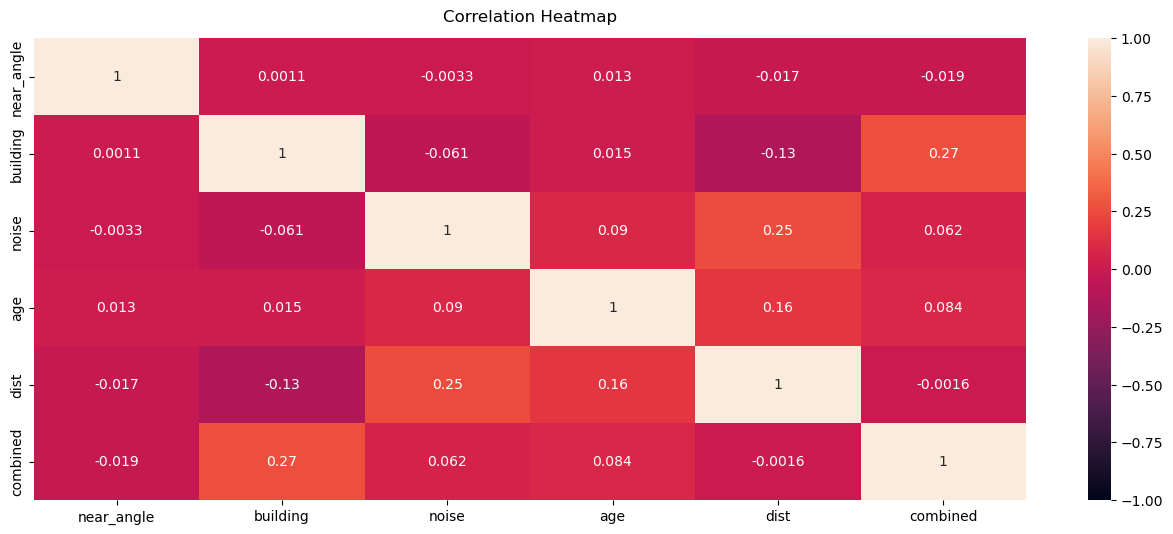

In [108]:
#Heatmap to show correlation between features, avoid highly correlating features
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_train_QDA.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [109]:
#My own feature selector

columns = X_train_QDA.columns
for column in columns:
    column_to_remove = column
    print("Column that was removed: ", column)
    columns_to_remove = [column]
    X_train_temp = X_train_QDA.copy().drop(columns=columns_to_remove, axis=1)
    y_train_temp = y_train
    
    # Extract features and target for testing set
    X_test_temp = X_test_QDA.copy().drop(columns=columns_to_remove, axis=1)
    y_test_temp = y_test

    qda_model = skl_da.QuadraticDiscriminantAnalysis()
    qda_model.fit(X_train_temp, y_train_temp)

    predict_prob_qda = qda_model.predict_proba(X_test_temp)

    prediction_qda = np.empty(len(X_test_temp), dtype=object)
    prediction_qda = np.where(predict_prob_lda[:, 0] >= 0.5, 0, 1) #0 is not heard, 1 is heard
    
    #Accuracy
    print(f"Accuracy: {np.mean(prediction_lda == y_test_temp):.3f}")




Column that was removed:  near_angle
Accuracy: 0.915
Column that was removed:  building
Accuracy: 0.915
Column that was removed:  noise
Accuracy: 0.915
Column that was removed:  age
Accuracy: 0.915
Column that was removed:  dist
Accuracy: 0.915
Column that was removed:  combined
Accuracy: 0.915


In [114]:
def perform_QDA():
    # QDA with SMOTE, standardscaler and gridsearch

    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_QDA, y_train)
    pipeline = make_pipeline(StandardScaler(), skl_da.QuadraticDiscriminantAnalysis())
    
    # Define hyperparameters grid for QDA
    param_grid = {
        'quadraticdiscriminantanalysis__reg_param': [0.0, 0.1, 0.5, 1.0]  # regularization parameter for QDA
    }

    np.random.seed(123)
    
    grid_search_qda = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search_qda.fit(X_train_resampled, y_train_resampled)
    
    # Get the best hyperparameters and their corresponding score
    print("Best hyperparameters:", grid_search_qda.best_params_)
    print("Best CV accuracy:", grid_search_qda.best_score_)
    
    # Use the best model obtained from grid search
    best_qda_model = grid_search_qda.best_estimator_
    
    # Predict on the testing dataset
    prediction_qda = best_qda_model.predict(X_test_QDA)
        
    # Perform cross-validation predictions on test set
    predicted = cross_val_predict(best_qda_model, X_test_QDA, y_test, cv=5)  # 5-fold cross-validation
    
    # Perform cross-validation
    cv_scores = cross_val_score(best_qda_model, X_train_QDA, y_train, cv=5, scoring='accuracy')
    
    # Generate classification report based on test set
    report = classification_report(y_test, predicted, digits=4)
    print(report)
    lines = report.strip().split('\n')
    accuracy_line = lines[-3]  # The third line from the end
    accuracy = float(accuracy_line.split()[1])

    result_dict = {}
    result_dict['accuracy'] = accuracy
    result_dict['f1'] = f1_score(y_test, prediction_lda)
    result_dict['balanced_accuracy'] = balanced_accuracy_score(y_test, prediction_lda)
    result_dict['precision'] = precision_score(y_test, prediction_lda)
    result_dict['recall'] = recall_score(y_test, prediction_lda)
    
    return result_dict

In [115]:
result_dict_QDA = perform_QDA()
print("---- QDA ----") 
print(result_dict_QDA)


Best hyperparameters: {'quadraticdiscriminantanalysis__reg_param': 0.0}
Best CV accuracy: 0.8147149878278445
              precision    recall  f1-score   support

           0     0.9308    0.7184    0.8110       206
           1     0.9169    0.9831    0.9489       651

    accuracy                         0.9195       857
   macro avg     0.9239    0.8508    0.8799       857
weighted avg     0.9202    0.9195    0.9157       857

---- QDA ----
{'accuracy': 0.9195, 'f1': 0.9451540195341849, 'balanced_accuracy': 0.8593165108197993, 'precision': 0.925, 'recall': 0.9662058371735791}


### Random Forest

In [104]:
# Random forest
model_tree = RandomForestClassifier(n_estimators=440, random_state=42) #defining which modell to be used
model_tree.fit(X_train, y_train)
model_tree_prediction = model_tree.predict(X_test)

print(pd.crosstab(model_tree_prediction, y_test))
print(f"acc: {np.mean(model_tree_prediction == y_test)}")

f1 = f1_score(y_test, model_tree_prediction)
balanced_acc = balanced_accuracy_score(y_test, model_tree_prediction)

# Compute precision and recall
precision = precision_score(y_test, model_tree_prediction)
recall = recall_score(y_test, model_tree_prediction)

print("F1-score:", f1)
print("Balanced Accuracy:", balanced_acc)
print("Precision:", precision)
print("Recall:", recall)

print(classification_report(y_test, model_tree_prediction, digits=4))



heard    0    1
row_0          
0      174   23
1       32  628
acc: 0.9358226371061844
F1-score: 0.9580472921434019
Balanced Accuracy: 0.9046649665190223
Precision: 0.9515151515151515
Recall: 0.9646697388632872
              precision    recall  f1-score   support

           0     0.8832    0.8447    0.8635       206
           1     0.9515    0.9647    0.9580       651

    accuracy                         0.9358       857
   macro avg     0.9174    0.9047    0.9108       857
weighted avg     0.9351    0.9358    0.9353       857



In [ ]:
# Boosting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV

# rescaling with standardscaler
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_test_rescaled = scaler.transform(X_test)

# Bagging classifier
bag = BaggingClassifier(random_state=42, n_estimators=20)
bag.fit(X_train_rescaled, y_train)
prediction = bag.predict(X_test_rescaled)

accuracy = bag.score(X_test_rescaled, y_test)

print("--- Bagging ---")
print(classification_report(y_test, prediction, digits=4))

In [ ]:
# Boosting with AdaBoost

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# rescaling with standardscaler
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_test_rescaled = scaler.transform(X_test)

#ada_boost = AdaBoostClassifier(random_state=42, n_estimators=100)
#ada_boost.fit(X_train_rescaled, Y_train)
#Y_predict = ada_boost.predict(X_test_rescaled)

#find best params with GridSearch


# Define the pipeline with preprocessing steps (e.g., scaling) and the AdaBoostClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional: preprocessing step
    ('adaboost', AdaBoostClassifier(random_state=42))  # AdaBoostClassifier
])

# Define the hyperparameter grid
param_grid = {
    'adaboost__learning_rate': [1, 2, 5, 10, 25]  # Learning rate hyperparameter for AdaBoostClassifier
}

# Perform Grid Search cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_rescaled, y_train)

# Print the best estimator and its hyperparameters
print("Best Estimator: ", grid_search.best_estimator_)

best_estimator = grid_search.best_estimator_

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define the pipeline with preprocessing steps (e.g., scaling) and the AdaBoostClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional: preprocessing step
    ('adaboost', AdaBoostClassifier(random_state=42))  # AdaBoostClassifier
])

# Define the hyperparameter grid including both n_estimators and learning_rate
param_grid = {
    'adaboost__n_estimators': [50, 100, 200],  # Number of estimators for AdaBoostClassifier
    'adaboost__learning_rate': [0.01, 0.1, 1.0, 2, 5, 10, 2]  # Learning rate for AdaBoostClassifier
}

# Perform Grid Search cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_rescaled, y_train)

# Print the best estimator and its hyperparameters
print("Best Estimator: ", grid_search.best_estimator_)


In [ ]:
# Best Adaboost classifier
best_boost = AdaBoostClassifier(random_state=42, n_estimators=200, learning_rate=0.1)
best_boost.fit(X_train_rescaled, y_train)
prediction = best_boost.predict(X_test_rescaled)

accuracy = best_boost.score(X_test_rescaled, y_test)

pred_accuracy_score = accuracy_score(y_test, prediction)
report = classification_report(y_test, prediction)

print("--- Best AdaBoost ---")
print(classification_report(y_test, prediction, digits=4))

##  Each model as a method to call

In [243]:
def perform_random_forest():
    model_tree = RandomForestClassifier(n_estimators=440, random_state=42) #defining which modell to be used
    model_tree.fit(X_train, y_train)
    model_tree_prediction = model_tree.predict(X_test)
    
    #Results
    result_dict = {}
    result_dict['accuracy'] = np.mean(model_tree_prediction == y_test)
    result_dict['f1'] = f1_score(y_test, model_tree_prediction)
    result_dict['balanced_accuracy'] = balanced_accuracy_score(y_test, model_tree_prediction)
    result_dict['precision'] = precision_score(y_test, model_tree_prediction)
    result_dict['recall'] = recall_score(y_test, model_tree_prediction)
    
    return result_dict

In [244]:
#Script to run all models to get balanced accuracies
#num_runs = 10
#lda_accuracy_array = []
#rf_accuracy_array = []

result_dict_lda = perform_LDA()
#lda_accuracy_array.append(result_dict_lda['accuracy'])
    
    #lda_accuracy_array.append(perform_LDA())
    #result_dict_rf = perform_random_forest()
    #rf_accuracy_array.append(result_dict_rf['accuracy'])

print("---- LDA ----") #Blended Accuracy: 0.8852
print(result_dict_lda)

#print("---- Random Forest ----") #Blended Accuracy: 0.9282
#print(f"Blended Accuracy: {np.mean(rf_accuracy_array):.4f}")
#

              precision    recall  f1-score   support

           0     0.9111    0.7961    0.8497       206
           1     0.9380    0.9754    0.9563       651

    accuracy                         0.9323       857
   macro avg     0.9245    0.8858    0.9030       857
weighted avg     0.9315    0.9323    0.9307       857

---- LDA ----
{'accuracy': 0.9030927835051547, 'f1': 0.9416342412451363, 'balanced_accuracy': 0.8942813893487241, 'precision': 0.9542586750788643, 'recall': 0.9293394777265745}
